# Ajuste del modelo $\Lambda$CDM con Union2 supernova data

Usaremos el AG para optimizar el estadistico Chi-Square statistic con el modelo:

\begin{equation*}
\frac{H(z)}{H(0)} = \sqrt{(1 - \Omega_m) + \Omega_m (1 + z)^3}
\end{equation*}

tomando $\Omega_m $ como unica variable en el intervalo $[0, 1]$. 

In [1]:
import random
import numpy as np
import scipy.constants as cte
from scipy.integrate import quad

import matplotlib.pyplot as plt
import seaborn as sns
from deap import base, creator, tools

import elitism
import time

In [2]:
# Cargamos los datos observacionales de las Supernovas, el archivo debe estar adjunto en la carpeta fuente.

z_obs, m_obs, dm_obs_stat = np.loadtxt("sn_z_mu_dmu_union2.dat", unpack=True)

dm_obs = dm_obs_stat

La distancia luminosidad será:

\begin{equation*}
d_{L} = (1+z) \int_{0}^{z} \frac{H_0}{\sqrt{(1 - \Omega_m) + \Omega_m (1 + z)^3}} dz
\end{equation*}

El módulo de distancia:

\begin{equation*}
\mu = m -  M = 5 \log {d_{L} + 25}
\end{equation*}

Y serán codificadas como sigue:

In [3]:
def luminosity_integrand(z, omgM):
    Ez = np.sqrt((1 - omgM) + omgM * np.power(1 + z, 3))
    return 1. / Ez

def luminosity_distance(z, omgM):
    h=0.72
    integral, _ = quad(luminosity_integrand, 0, z, epsrel=1e-8, args=(omgM))
    return (cte.c / 10. ** 5) / h * (1 + z) * integral

def distance_modulus(z, omgM):
    return 5. * np.log10(luminosity_distance(z, omgM)) + 25.

Definimos el estadistico Chi-square marginalizado: 

\begin{equation*}
    \chi^2_{SN} = X - \frac{Y^2}{Z} + \log(\frac{Z}{2\pi}),    
\end{equation*}

donde:

\begin{equation*}
    X = \sum^N_{i=1} \frac{\big[\mu_{th}(z_i) - \mu_i   \big]^2}{\sigma^2(z_i)},
\end{equation*}

\begin{equation*}
    Y = \sum^N_{i=1} \frac{\mu_{th}(z_i) - \mu_i}{\sigma^2(z_i)},
\end{equation*}
\begin{equation*}
    Z = \sum^N_{i=1} \frac{1}{\sigma^2(z_i)}.
\end{equation*}

La distribución del parámetro es: 

\begin{equation*}
    P(\theta_{i}) = \mathcal{N} e^{-\chi^2(\theta_{i})/2} 
\end{equation*}

donde $\mathcal{N}$ es una constante de normalización. Si $\chi^2_{min}/(N-n) \lesssim 1$ el ajuste es bueno y el modelo es consistente con los datos.

In [4]:
def X(omgM):
    m_model = np.array([distance_modulus(z, omgM) for z in z_obs])
    X_vec = np.power(((m_model - m_obs) / dm_obs), 2)
    return X_vec.sum()

def Y(omgM):
    m_model = np.array([distance_modulus(z, omgM) for z in z_obs])
    Y_vec = (m_model - m_obs) / dm_obs**2
    return Y_vec.sum()

def Z(omgM):
    m_model = np.array([distance_modulus(z, omgM) for z in z_obs])
    Z_vec = 1.0/dm_obs**2
    return Z_vec.sum()

def chisq(individual):
    omgM=individual[0]

    m_model = np.array([distance_modulus(z, omgM) for z in z_obs])
    chisq_vec = X(omgM) - Y(omgM)**2/Z(omgM) + np.log10(Z(omgM)/2*np.pi)
    f=chisq_vec.sum()
    return f,

Y preparamos el algoritmo genético

In [5]:
DIMENSIONS = 1  
BOUND_LOW, BOUND_UP = 0.0, 1.0 

In [6]:
POPULATION_SIZE = 30
P_CROSSOVER = 0.6  
P_MUTATION = 0.4   
MAX_GENERATIONS = 20
HALL_OF_FAME_SIZE = 3   
CROWDING_FACTOR = 20.0  

In [7]:
toolbox = base.Toolbox()

In [8]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

In [9]:
creator.create("Individual", list, fitness=creator.FitnessMin)

In [10]:
def randomFloat(low, up):
    return [random.uniform(l, u) for l, u in zip([low] * DIMENSIONS, [up] * DIMENSIONS)]

toolbox.register("attrFloat", randomFloat, BOUND_LOW, BOUND_UP)

toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.attrFloat)

toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

Aquí introduciomos la función a optimizar

In [11]:
toolbox.register("evaluate", chisq)

In [12]:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR, 
                 indpb=1.0/DIMENSIONS)

In [13]:
def main():

    population = toolbox.populationCreator(n=POPULATION_SIZE)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    #stats.register("max", np.max)
    stats.register("avg", np.mean)

    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    population, logbook = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])

    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")

    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Min / Average Fitness')
    plt.title('Min and Average fitness over Generations')

    plt.show()
    
    return best

gen	nevals	min    	avg    
0  	30    	547.143	722.072
1  	22    	547.143	623.973
2  	21    	547.143	585.798
3  	20    	547.143	558.447
4  	19    	547.143	553.755
5  	21    	547.143	550.25 
6  	22    	547.143	550.775
7  	25    	547.143	552.616
8  	21    	547.143	556.026
9  	19    	547.143	550.838
10 	25    	547.143	557.901
11 	16    	547.143	548.592
12 	15    	547.143	547.361
13 	22    	547.143	551.958
14 	18    	547.143	551.934
15 	27    	547.143	551.139
16 	23    	547.143	553.952
17 	22    	547.143	548.297
18 	21    	547.143	552.98 
19 	24    	547.143	550.43 
20 	20    	547.143	550.959
-- Best Individual =  [0.27036908833595963]
-- Best Fitness =  547.1434619697453


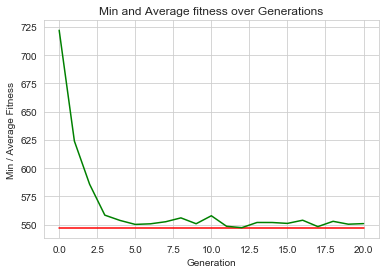

102.40934681892395


In [14]:
inicio = time.time()

best_sol = main()

fin = time.time()
print(fin-inicio)

In [15]:
best_sol = best_sol[0]

Y graficamos el resultado junto con los datos

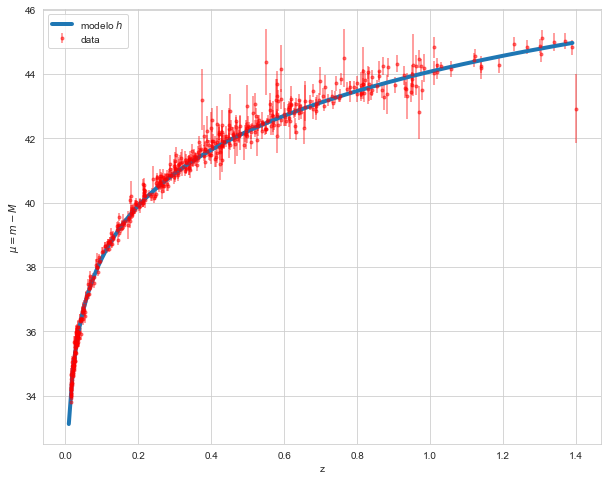

In [16]:
zs = np.arange(0.01, 1.4, 0.01)
distance_modulus_best_omgM = np.vectorize(lambda z : distance_modulus(z, best_sol))

plt.figure(figsize=(10, 8))
plt.xlabel("z")
plt.ylabel(r"$\mu = m - M$")
plt.plot(zs, distance_modulus_best_omgM(zs), label="modelo $h$", linewidth=4)
plt.errorbar(z_obs, m_obs, dm_obs, fmt='r.', label=r"data", alpha=0.5)
plt.legend();
#plt.savefig('resultado_1.png')